## FER2013
FER2013数据集由48x48像素的灰度人脸图像组成。这些人脸图像已经经过自动对齐处理，因此每张图中的人脸大致居中，并且在图像中所占的空间基本相同。

任务是根据人脸表情中显示的情绪，将每张人脸分类到七种情绪类别之一（0=愤怒，1=厌恶，2=恐惧，3=高兴，4=悲伤，5=惊讶，6=中性）。训练集包含28,709个样本，公开测试集包含3,589个样本。

数据集地址：https://www.kaggle.com/datasets/msambare/fer2013

## ⚙️ 参数与环境配置

本节配置了训练所需的参数与环境，适用于在 Jupyter Notebook 中直接运行。我们使用 `argparse.Namespace` 来模拟命令行参数输入，这在 Notebook 中比使用 `argparse.ArgumentParser` 更加方便。

### 参数说明：
- `model_type`：模型类型，支持 `'simplecnn'` 和 `'resnet18'`。
- `image_size`：输入图像的尺寸，FER2013 数据集中默认为 `48`。
- `num_input_channels`：根据模型选择，预处理输入图像的通道数，灰度图像为 `1`，彩色图像为 `3`。
- `pretrained_path`：可选参数，用于指定预训练模型的路径。
- `use_tiny_dataset`：是否使用子集进行快速验证和调试。

### 其他配置：
- `device`：根据是否有 CUDA 支持自动选择运行设备（GPU 或 CPU）。
- `data_root`：数据集路径，默认指向本地 `./FER2013` 文件夹。
- `model_save_path`：模型训练完成后的保存路径。
- `log_dir`：用于 TensorBoard 的日志保存目录。
- `use_tiny_dataset`：控制是否使用小数据集加快测试速度，正式训练时应设为 `False`。

In [ ]:
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
from sklearn.metrics import confusion_matrix

args = argparse.Namespace(
    model_type='simplecnn',
    image_size=48,
    num_input_channels=1,
    pretrained_path=None,
    use_tiny_dataset=False  # or False
)

# -----------------------------
# 配置
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = './FER2013'
model_save_path = f'./checkpoints/{args.model_type}_fer2013.pth'
log_dir = f'./logs/fer2013_{args.model_type}'
use_tiny_dataset = False # 默认False，使用True用来在子数据集上进行快速验证

## 🧹 数据预处理与加载

本节定义了图像数据的预处理操作与数据加载方式，适用于 FER2013 情感识别数据集。

### 数据预处理流程：
- `Grayscale`：将图像转换为灰度图，通道数设为 1（适配 SimpleCNN）。
- `ToTensor`：将图像转换为张量格式。
- `Normalize`：将像素值标准化到 [-1, 1] 区间，使用均值 `0.5` 和标准差 `0.5`。

### 数据集加载：
- 使用 `ImageFolder` 从 `train` 和 `test` 文件夹中加载图像数据。
- 如果设置了 `use_tiny_dataset=True`，则从训练和验证集中各随机抽取 1000 个样本用于快速测试与调试。

### 数据加载器：
- `train_loader`：训练集加载器，启用 shuffle 和多线程（2个 worker）。
- `val_loader`：验证集加载器，禁用 shuffle，用于评估模型性能。

In [ ]:
# -----------------------------
# 数据预处理与加载
# -----------------------------
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_root, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_root, 'test'), transform=transform)


if use_tiny_dataset:
    # 使用小数据集进行测试
    train_dataset = torch.utils.data.Subset(train_dataset, random.sample(range(len(train_dataset)), 1000))
    val_dataset = torch.utils.data.Subset(val_dataset, random.sample(range(len(val_dataset)), 1000))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)

## 🖼️ 类别样例图展示

本节用于从训练数据集中各类别中各选取一张图像进行可视化，帮助理解 FER2013 数据集中的不同情绪类别。

### 实现细节：
- 使用 `emotion_labels` 字典将类别索引映射为情绪名称（如 "Angry"、"Happy" 等）。
- `show_examples_per_class` 函数会遍历数据集，为每个类别选择第一张未展示的样本图像。
- 每张图像使用 `matplotlib` 显示，灰度模式渲染，标题显示对应情绪类别。

### 输出：
- 展示 7 张图像，每张对应一个情绪类别，有助于对数据分布有直观认识。

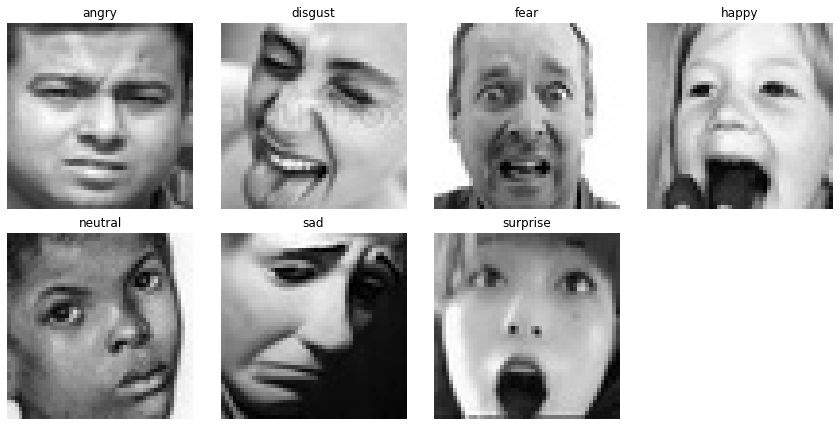

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
import os

# Emotion labels
# Emotion labels based on ImageFolder alphabetical indexing
emotion_labels = {
    0: "angry",     # angry
    1: "disgust",   # disgust
    2: "fear",      # fear
    3: "happy",     # happy
    4: "neutral",   # neutral
    5: "sad",       # sad
    6: "surprise"   # surprise
}

# 显示每个类别的一张样本图像
def show_examples_per_class(dataset, num_classes=7):
    shown = [False] * num_classes
    plt.figure(figsize=(12, 6))
    count = 0

    for img, label in dataset:
        if not shown[label]:
            img = img.squeeze().numpy()*0.5+0.5  # Remove channel dim for grayscale
            plt.subplot(2, 4, label + 1)
            plt.imshow(img, cmap='gray')
            plt.title(emotion_labels[label])
            plt.axis('off')
            shown[label] = True
            count += 1
        if count == num_classes:
            break
    plt.tight_layout()
    plt.show()
    
show_examples_per_class(train_dataset)

## 🧠 SimpleCNN 模型定义

本节定义了一个轻量级卷积神经网络 `SimpleCNN`，适用于 FER2013 表情识别任务。该模型结构简单，适合中小规模数据集的训练和调试。

### 模型结构：

#### 特征提取部分（Feature Extractor）：
- 使用三层卷积块（`Conv2d + ReLU + MaxPool2d`）逐步提取图像的空间层级特征。
- 输入为 1 通道灰度图，输出通道依次为 32 → 64 → 128。
- 每次池化操作将尺寸减半，最终特征图大小为 6×6。

#### 自适应池化（AdaptiveAvgPool2d）：
- 将最终特征图缩减为 1×1×128，提升模型泛化能力并减少参数量。

#### 分类器部分（Classifier）：
- 展平特征图后送入全连接层，依次为：
  - `Linear(128 → 256)`
  - `ReLU`
  - `Dropout(0.5)` 用于防止过拟合
  - `Linear(256 → num_classes)` 输出每个情绪类别的预测概率。

### 前向传播逻辑：
1. 输入图像通过卷积提取特征；
2. 应用自适应平均池化；
3. 将提取的特征送入分类器进行分类预测。

> 适用于灰度图（如 FER2013），具有良好的运行效率和可调试性。

In [5]:
import torch
import torch.nn as nn

# -----------------------------
# SimpleCNN 模型定义
# -----------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 24x24

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 6x6
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

## 📈 训练过程可视化函数

本函数 `plot_metrics` 用于绘制模型训练与验证过程中的准确率与损失曲线，并将结果保存为图片：

- **输入参数**：
  - `log_dir`：保存图像的文件夹路径
  - `train_accuracies` / `val_accuracies`：训练与验证准确率序列
  - `train_losses` / `val_losses`：训练与验证损失值序列

- **功能**：
  - 绘制并保存两张图：
    - **准确率曲线图**（accuracy_plot.png）
    - **损失曲线图**（loss_plot.png）

用于分析模型在每轮训练过程中的性能变化。

In [6]:
# -----------------------------
# 可视化函数
# -----------------------------
def plot_metrics(log_dir, train_accuracies, val_accuracies, train_losses, val_losses):
    plt.figure()
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(val_accuracies, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Train vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{log_dir}/accuracy_plot.png")
    plt.close()

    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{log_dir}/loss_plot.png")
    plt.close()


## 模型评估函数

该函数在验证集上评估模型的准确率与损失，并返回混淆矩阵。

- 模型设为评估模式（`model.eval()`）。
- 遍历验证数据集，计算损失与预测结果。
- 使用 `sklearn.metrics.confusion_matrix` 生成混淆矩阵。
- 返回验证准确率、平均损失和混淆矩阵。

In [7]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(val_loader)
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, avg_loss, cm

## 🏋️‍♀️ 模型训练函数：`train_model`

该函数用于训练模型并在验证集上评估性能，支持 TensorBoard 可视化与早停机制。

### 🔧 输入参数：
- `model`：待训练的神经网络模型
- `train_loader`：训练数据加载器
- `val_loader`：验证数据加载器
- `criterion`：损失函数（如 `nn.CrossEntropyLoss`）
- `optimizer`：优化器（如 `torch.optim.Adam`）
- `device`：运行设备（'cuda' 或 'cpu'）
- `log_dir`：TensorBoard 日志保存路径
- `model_save_path`：模型权重保存路径
- `num_epochs`：最大训练轮数（默认 30）
- `patience`：早停容忍轮数（默认 5）

### 📈 功能说明：
- 在每一轮训练中：
  - 执行前向传播、反向传播与优化
  - 记录训练损失与准确率
  - 在验证集上评估并记录性能
- 使用 TensorBoard 保存指标
- 每轮绘制准确率和损失图像
- 若验证集损失持续 `patience` 轮未改善，则触发早停
- 保存验证损失最低的模型权重

### 📤 输出：
无返回值，但保存训练过程中的日志、图像和最优模型参数。

用于完整训练流程的核心函数。

In [8]:
# -----------------------------
# 训练函数
# -----------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, device, log_dir, model_save_path, num_epochs=30, patience=5):
    writer = SummaryWriter(log_dir)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_acc, val_loss, cm = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} - "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        plot_metrics(log_dir, train_accuracies, val_accuracies, train_losses, val_losses)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print("Validation loss improved. Model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}. No improvement in {patience} epochs.")
                break

    writer.close()

In [9]:
# -----------------------------
# 主流程
# -----------------------------
if __name__ == "__main__":
    print("Starting training on FER-2013 at 48x48 resolution...")

    model = SimpleCNN(num_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, val_loader, criterion, optimizer, device, log_dir, model_save_path, num_epochs=30, patience=5)

    print("Training finished.")

Starting training on FER-2013 at 48x48 resolution...
Epoch [1/30] - Train Loss: 1.8791, Val Loss: 1.7902 - Train Acc: 18.80%, Val Acc: 26.00%
Validation loss improved. Model saved.
Epoch [2/30] - Train Loss: 1.8129, Val Loss: 1.7858 - Train Acc: 22.70%, Val Acc: 26.00%
Validation loss improved. Model saved.
Epoch [3/30] - Train Loss: 1.8062, Val Loss: 1.7744 - Train Acc: 24.50%, Val Acc: 26.00%
Validation loss improved. Model saved.
Epoch [4/30] - Train Loss: 1.7854, Val Loss: 1.7800 - Train Acc: 23.50%, Val Acc: 26.00%
Epoch [5/30] - Train Loss: 1.7916, Val Loss: 1.7682 - Train Acc: 24.40%, Val Acc: 25.80%
Validation loss improved. Model saved.
Epoch [6/30] - Train Loss: 1.7767, Val Loss: 1.7640 - Train Acc: 25.10%, Val Acc: 26.00%
Validation loss improved. Model saved.
Epoch [7/30] - Train Loss: 1.7787, Val Loss: 1.7674 - Train Acc: 23.60%, Val Acc: 26.70%
Epoch [8/30] - Train Loss: 1.7786, Val Loss: 1.7702 - Train Acc: 25.60%, Val Acc: 26.00%
Epoch [9/30] - Train Loss: 1.7719, Val L

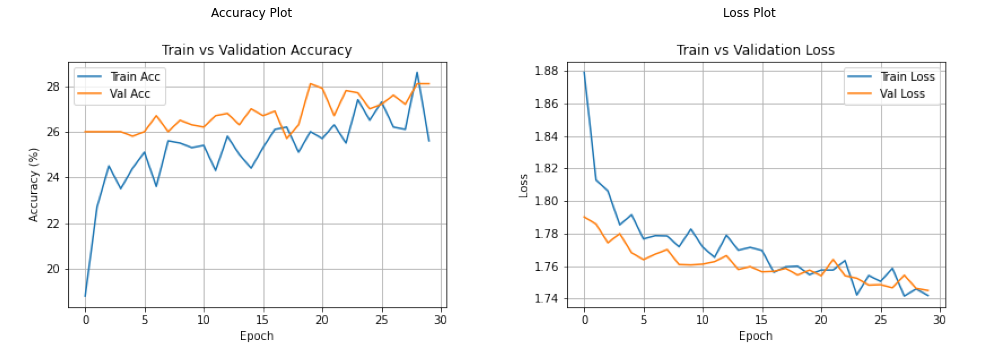

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image paths
accuracy_plot_path = f"{log_dir}/accuracy_plot.png"
loss_plot_path = f"{log_dir}/loss_plot.png"

# Load images
accuracy_img = mpimg.imread(accuracy_plot_path)
loss_img = mpimg.imread(loss_plot_path)

# Create a figure to display both plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Display the accuracy plot
axes[0].imshow(accuracy_img)
axes[0].axis('off')
axes[0].set_title('Accuracy Plot')

# Display the loss plot
axes[1].imshow(loss_img)
axes[1].axis('off')
axes[1].set_title('Loss Plot')

plt.tight_layout()
plt.show()

In [11]:
# 自定义标签
emotion_labels = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprise"
}

# 在model_save_path上评估模型
model.load_state_dict(torch.load(model_save_path))
val_acc, val_loss, cm = evaluate_model(model, val_loader, criterion, device)
print(f"Final Validation Accuracy: {val_acc:.2f}%, Final Validation Loss: {val_loss:.4f}")
print("Confusion Matrix:")
print(cm)

# 画出混淆矩阵
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# 使用自定义标签
tick_marks = range(len(emotion_labels))
label_names = [emotion_labels[i] for i in tick_marks]
plt.xticks(tick_marks, label_names, rotation=45)
plt.yticks(tick_marks, label_names)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(f"{log_dir}/confusion_matrix.png")
plt.close()
print("Confusion matrix saved.")

/var/folders/6j/_3d0_q391w7c3rk2g2r1y7_00000gn/T/ipykernel_17989/2932202715.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_

Final Validation Accuracy: 28.10%, Final Validation Loss: 1.7451
Confusion Matrix:
[[  0   0  10 106   6   0   8]
 [  0   0   2   8   0   0   1]
 [  0   0  13 114   2   0   9]
 [  0   0   5 238   9   0   8]
 [  0   0   6 139  14   0  10]
 [  0   0   6 164  10   0   5]
 [  0   0  19  72   0   0  16]]
Confusion matrix saved.


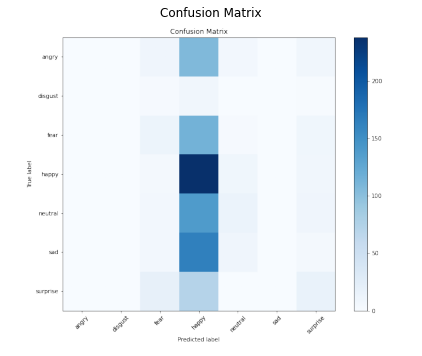

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the confusion matrix image
confusionmatrix_plot_path = f"{log_dir}/confusion_matrix.png"

# Load the image
confusion_matrix_img = mpimg.imread(confusionmatrix_plot_path)

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_img)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()